# Imports & globals

In [1]:
import sys
sys.path.append("/home/cbarkhof/fall-2021")

In [2]:
%config InlineBackend.figure_format='retina'
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from analysis_run_postprocessing.general_postprocessing_steps import *
from latent_analysis import plot_latents

import pandas as pd
import numpy as np
import torch

In [3]:
DEVICE = "cuda:0"
EXPORT_DIR = f"{CODE_DIR}/analysis_run_postprocessing/run_postprocess_files"
ENCODING_FILE = "encodings.pt"

# Fetch overview relevant runs from W&B

In [4]:
run_df = pd.read_csv("/home/cbarkhof/fall-2021/analysis/final_selection_runs.csv", index_col=0)

global_stats_df = pd.read_csv("/home/cbarkhof/fall-2021/analysis/global_stats.csv", index_col=0)
global_stats_df = global_stats_df[(global_stats_df.index.isin(run_df.index)) \
                                  & (global_stats_df.phase == "valid")]

print(len(run_df), len(global_stats_df), len(global_stats_df[global_stats_df.image_or_language == "image"]), len(global_stats_df[global_stats_df.image_or_language == "language"]))
run_df.head()

89 89 66 23


,objective,l_rate,dataset,image_or_language,beta_beta,free_bits,mdr_value,l_mmd,decoder,run_name
INFO-VAE l_Rate 0.1 l_MMD 1 dec: CNN.T,INFO-VAE,0.1,bmnist,image,0.0,0,0,1,basic_deconv_decoder,"(inf-vae-exp 5 oct) INFO-VAE[l_1_rate=0.1, l_2..."
INFO-VAE l_Rate 0.1 l_MMD 1 dec: PixelCNN++,INFO-VAE,0.1,bmnist,image,0.0,0,0,1,cond_pixel_cnn_pp,"(inf-vae-exp 5 oct) INFO-VAE[l_1_rate=0.1, l_2..."
INFO-VAE l_Rate 0.1 l_MMD 10 dec: CNN.T,INFO-VAE,0.1,bmnist,image,0.0,0,0,10,basic_deconv_decoder,"(20-jan bmnist) INFO-VAE[l_1_rate=0.1, l_2_mmd..."
INFO-VAE l_Rate 0.1 l_MMD 10 dec: PixelCNN++,INFO-VAE,0.1,bmnist,image,0.0,0,0,10,cond_pixel_cnn_pp,"(20-jan bmnist) INFO-VAE[l_1_rate=0.1, l_2_mmd..."
INFO-VAE l_Rate 0.1 l_MMD 100 dec: CNN.T,INFO-VAE,0.1,bmnist,image,0.0,0,0,100,basic_deconv_decoder,"(inf-vae-exp 5 oct) INFO-VAE[l_1_rate=0.1, l_2..."


In [5]:
# Check if any encodings from experiments are missing
missing_df = overview_of_missing_analysis(run_df)
missing = missing_df["encode"].sum()
print(f"Encode files missing: {missing}/{len(missing_df)}")

Encode files missing: 0/89


# Load some global stats on the runs to plot against later on

In [6]:
global_stats_df = pd.read_csv("/home/cbarkhof/fall-2021/analysis/global_stats.csv", index_col=0)
global_stats_df = global_stats_df[global_stats_df.phase == "valid"]
global_stats_df = global_stats_df[global_stats_df.index.isin(run_df.index)]
print(len(global_stats_df) == len(run_df))
global_stats_df.head()

True


,phase,IW LL,MMD,PPL,distortion,elbo,kl_prior_post,mean_mean,mean_scale,std_across_x_mean,...,objective,l_rate,dataset,image_or_language,beta_beta,free_bits,mdr_value,l_mmd,decoder,run_name
INFO-VAE l_Rate 0.1 l_MMD 1 dec: CNN.T,valid,-102.698863,0.109114,NaN,67.664685,-105.651187,37.986501,0.170109,0.036762,1.317382,...,INFO-VAE,0.1,bmnist,image,0.0,0,0,1,basic_deconv_decoder,"(inf-vae-exp 5 oct) INFO-VAE[l_1_rate=0.1, l_2..."
INFO-VAE l_Rate 0.1 l_MMD 1 dec: PixelCNN++,valid,-92.494255,0.063386,NaN,50.566032,-96.655054,46.089022,-0.133279,0.013563,1.163724,...,INFO-VAE,0.1,bmnist,image,0.0,0,0,1,cond_pixel_cnn_pp,"(inf-vae-exp 5 oct) INFO-VAE[l_1_rate=0.1, l_2..."
INFO-VAE l_Rate 0.1 l_MMD 10 dec: CNN.T,valid,-112.413061,0.055015,NaN,78.978573,-115.686587,36.708014,-0.000317,0.034395,1.137021,...,INFO-VAE,0.1,bmnist,image,0.0,0,0,10,basic_deconv_decoder,"(20-jan bmnist) INFO-VAE[l_1_rate=0.1, l_2_mmd..."
INFO-VAE l_Rate 0.1 l_MMD 10 dec: PixelCNN++,valid,-92.755143,0.021386,NaN,60.909976,-96.713169,35.803194,-0.032250,0.030254,1.008456,...,INFO-VAE,0.1,bmnist,image,0.0,0,0,10,cond_pixel_cnn_pp,"(20-jan bmnist) INFO-VAE[l_1_rate=0.1, l_2_mmd..."
INFO-VAE l_Rate 0.1 l_MMD 100 dec: CNN.T,valid,-99.629755,0.003865,NaN,68.233109,-102.593689,34.360581,-0.024068,0.037264,1.021284,...,INFO-VAE,0.1,bmnist,image,0.0,0,0,100,basic_deconv_decoder,"(inf-vae-exp 5 oct) INFO-VAE[l_1_rate=0.1, l_2..."


# Gather encodings for relevant runs from disk

In [7]:
all_encodings = dict()

for image_or_language, group_df in run_df.groupby("image_or_language"):
    
    all_encodings[image_or_language] = dict()
    
    for i, (clean_name, row) in enumerate(group_df.iterrows()):
        p = f"{EXPORT_DIR}/{row.run_name}/{ENCODING_FILE}"

        encodings = torch.load(p)
        encodings = encodings["valid"]

        if i == 0:
            print("-"*40)
            print(image_or_language.upper())
            for k, v in encodings.items(): print(k, v.shape)
            print()

        encodings["run_name"] = row.run_name

        all_encodings[image_or_language][clean_name] = encodings

----------------------------------------
IMAGE
z torch.Size([10000, 10])
mean torch.Size([10000, 10])
scale torch.Size([10000, 10])

----------------------------------------
LANGUAGE
z torch.Size([3370, 32])
mean torch.Size([3370, 32])
scale torch.Size([3370, 32])



# Plot

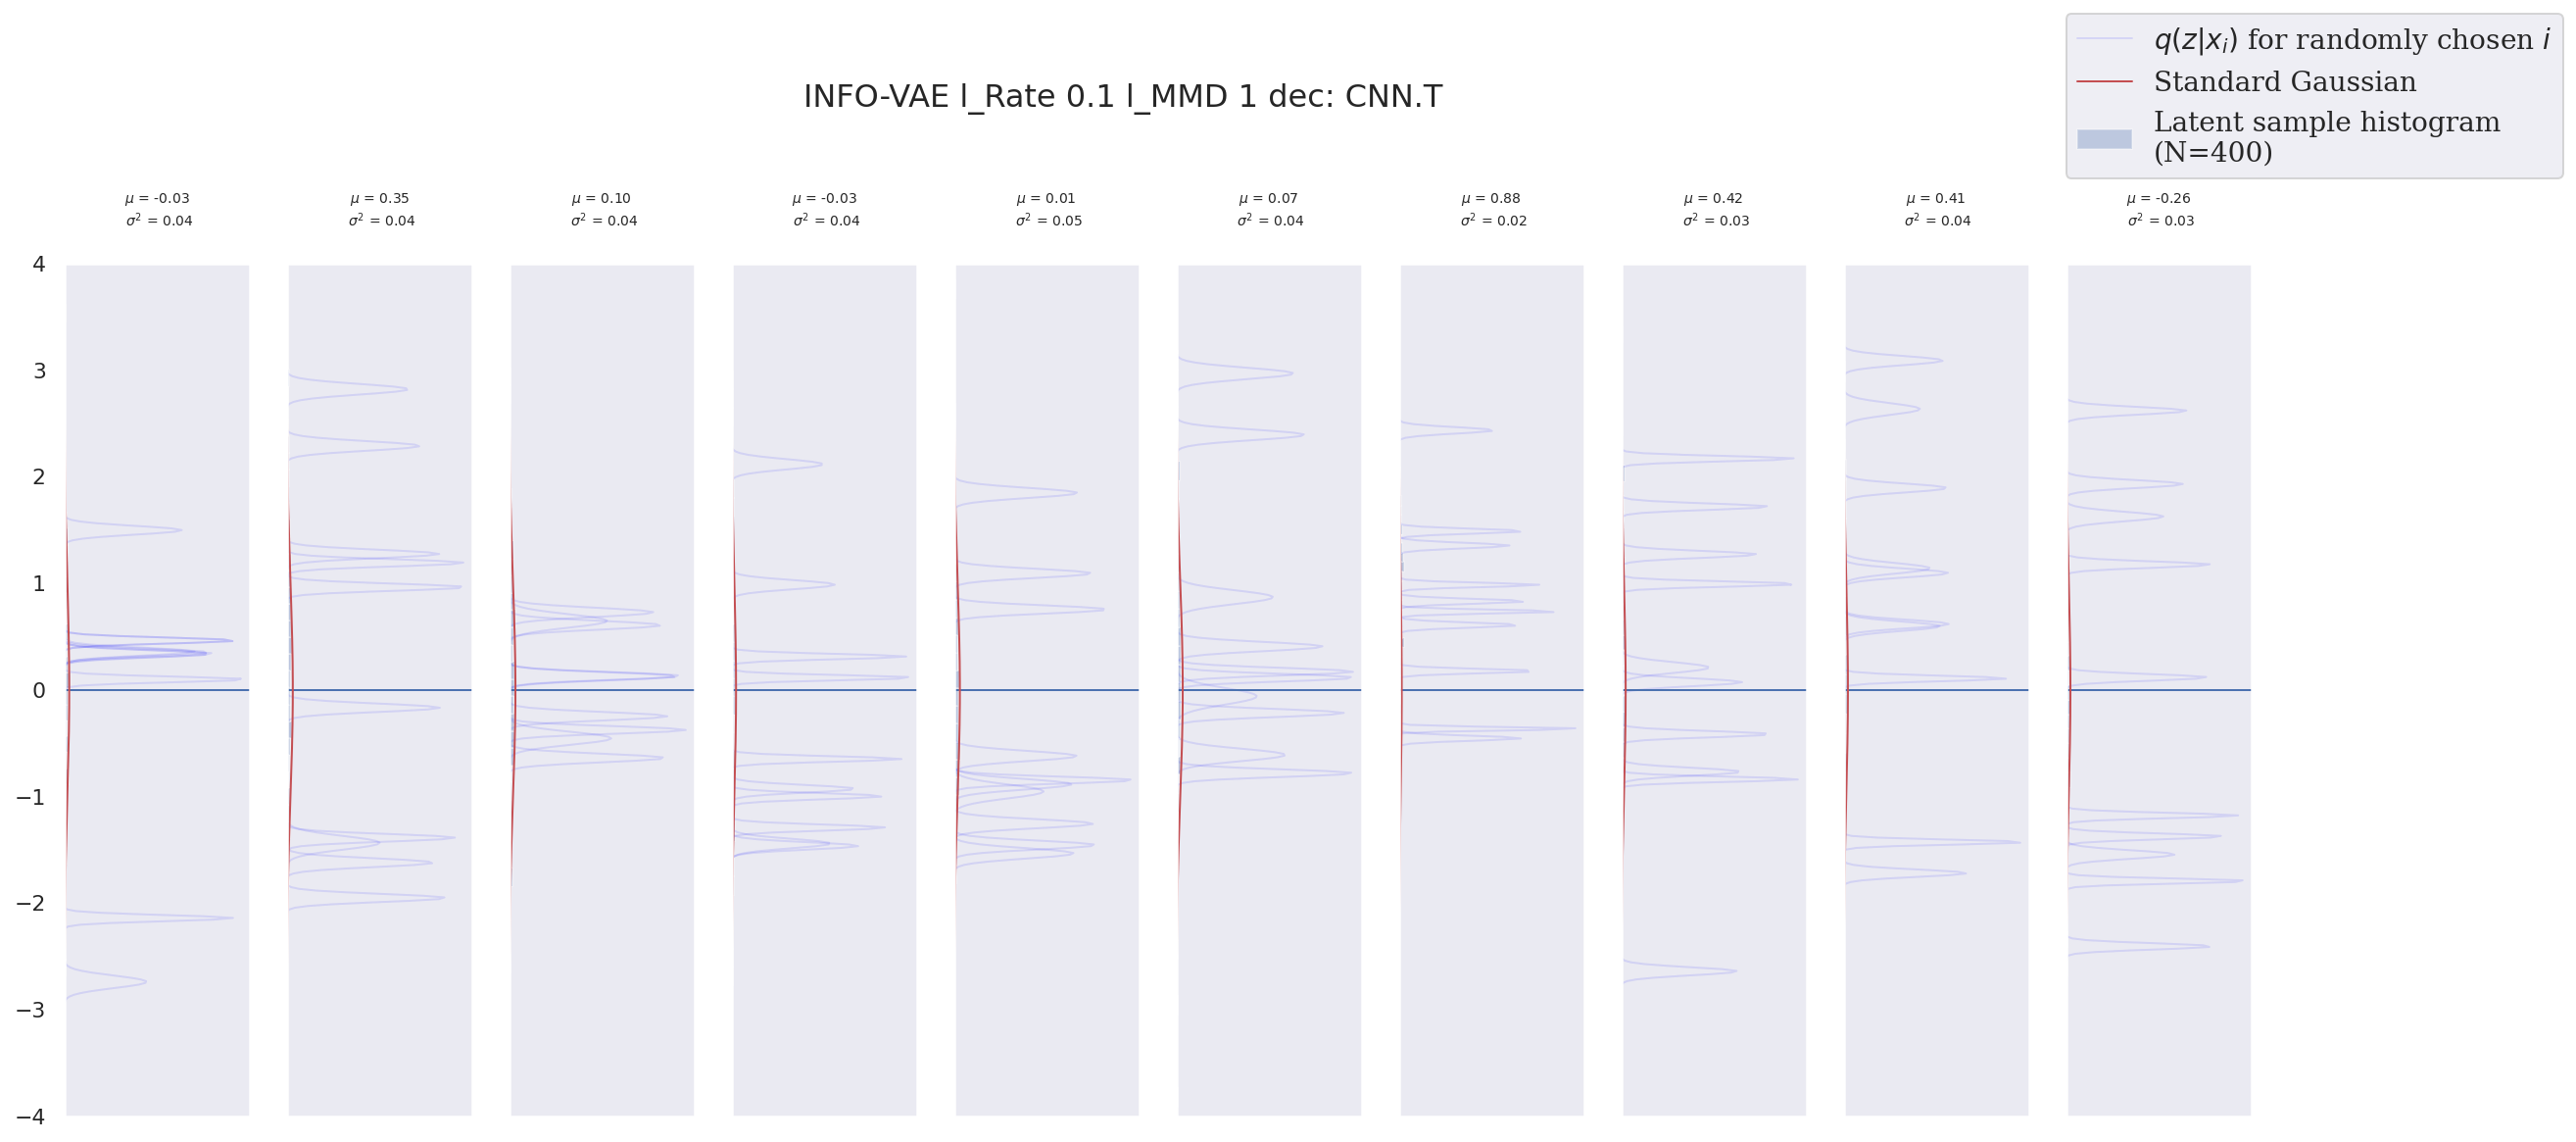

KeyboardInterrupt: 

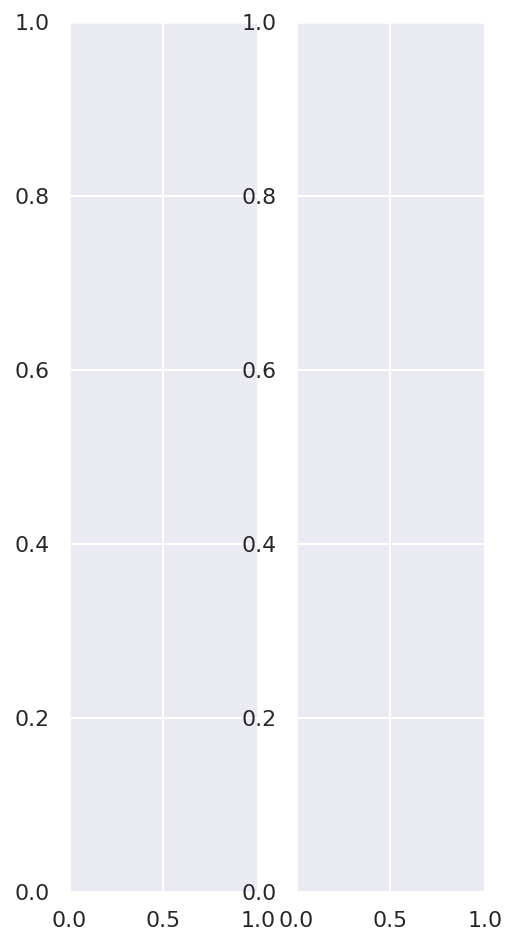

In [15]:
for image_or_language in ["image", "language"]:
    for i, (clean_name, encodings) in enumerate(all_encodings[image_or_language].items()):

        plot_latents(encodings, clean_name, plot_N_sep_posteriors=10, plot_N_encodings=400)

        if i == 0: break

# Compute some statistics (Kolgomorov-Smirnov, MMD and rate)

In [8]:
from analysis.bda_models.bda_MM_latent_analysis import *

recompute = False
language_save_file = "language_encoding_stats.csv"
image_save_file = "image_encoding_stats.csv"

if (not (os.path.isfile(language_save_file) and os.path.isfile(image_save_file))) or recompute:

    language_encoding_stats = gather_alternative_statistics(encodings=all_encodings["language"], 
                                                            N_encodings=2000, 
                                                            latent_dim=32)

    image_encoding_stats = gather_alternative_statistics(encodings=all_encodings["image"], 
                                                         N_encodings=2000, 
                                                         latent_dim=10)

    language_encoding_stats_df = pd.DataFrame(language_encoding_stats).transpose()
    image_encoding_stats_df = pd.DataFrame(image_encoding_stats).transpose()
    
    language_encoding_stats_df.to_csv(language_save_file)
    image_encoding_stats_df.to_csv(image_save_file)
else:
    
    language_encoding_stats_df = pd.read_csv(language_save_file, index_col=0)
    image_encoding_stats_df = pd.read_csv(image_save_file, index_col=0)
    
display(language_encoding_stats_df.head())
display(image_encoding_stats_df.head())

,mmd,one_sample_ks,two_sample_kl,rate
INFO-VAE l_Rate 0.1 l_MMD 1 dec: Strong roBERTa,0.000958,0.018885,0.018875,51.250126
INFO-VAE l_Rate 0.1 l_MMD 10 dec: Strong roBERTa,0.000920,0.018879,0.018312,51.565178
INFO-VAE l_Rate 0.1 l_MMD 100 dec: Strong roBERTa,0.000727,0.009407,0.010422,48.640194
INFO-VAE l_Rate 0.5 l_MMD 1 dec: Strong roBERTa,0.000115,0.006152,0.006672,4.422532
INFO-VAE l_Rate 0.5 l_MMD 10 dec: Strong roBERTa,0.000145,0.007167,0.009625,4.539146


,mmd,one_sample_ks,two_sample_kl,rate
INFO-VAE l_Rate 0.1 l_MMD 1 dec: CNN.T,0.117599,0.118061,0.11935,38.192043
INFO-VAE l_Rate 0.1 l_MMD 1 dec: PixelCNN++,0.065758,0.062574,0.06430,45.915852
INFO-VAE l_Rate 0.1 l_MMD 10 dec: CNN.T,0.061364,0.038690,0.04120,36.686001
INFO-VAE l_Rate 0.1 l_MMD 10 dec: PixelCNN++,0.024855,0.014071,0.01915,35.765266
INFO-VAE l_Rate 0.1 l_MMD 100 dec: CNN.T,0.004414,0.017408,0.02360,34.324852


I0210 16:42:26.663357 23192927092480 utils.py:145] Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
I0210 16:42:26.664837 23192927092480 utils.py:157] NumExpr defaulting to 8 threads.


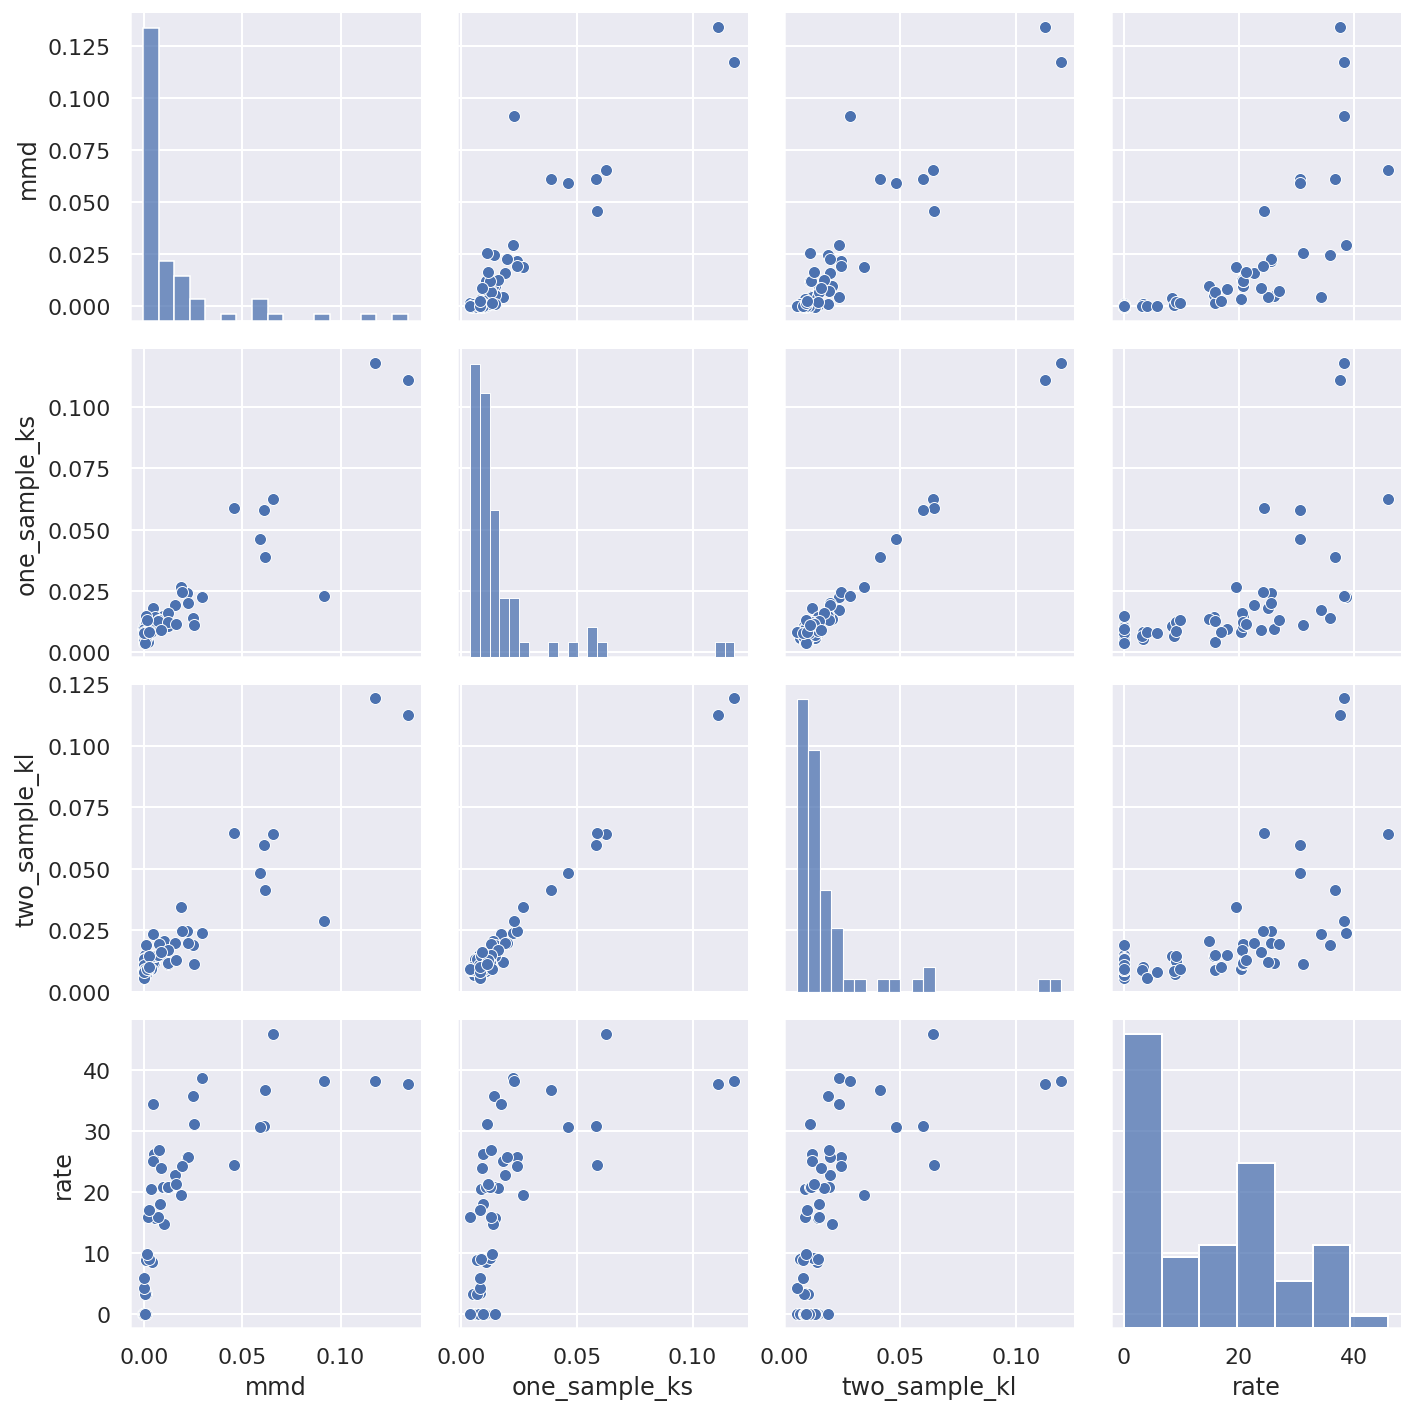

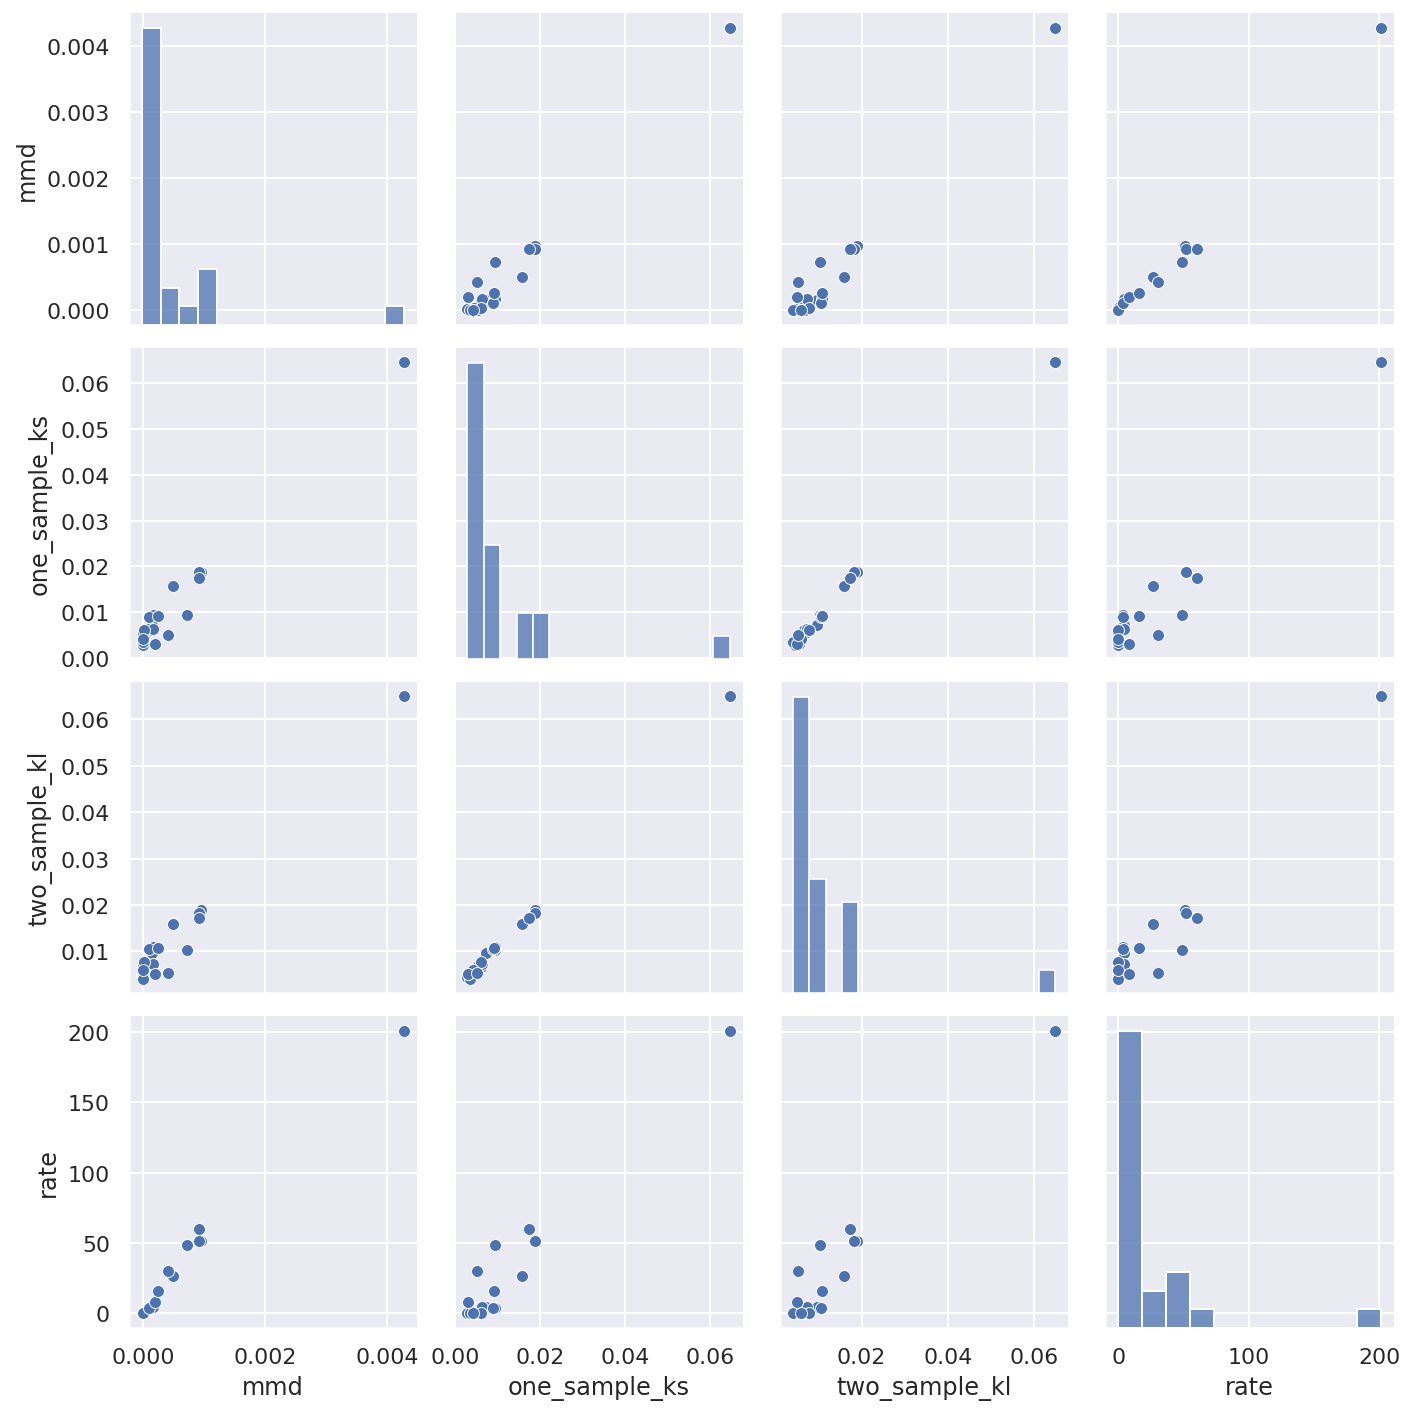

In [9]:
sns.pairplot(image_encoding_stats_df)
# sns.pairplot(language_encoding_stats_df)
# language_encoding_stats_df_filter = language_encoding_stats_df[language_encoding_stats_df.rate < 100]
sns.pairplot(language_encoding_stats_df)

In [10]:
def kl_comp_data_group_model_groups(self, posterior_predict_n_samples=600, resample_post=False):
    if self.posterior is None or resample_post:
        self.posterior = self.model.posterior_predict(num_samples=posterior_predict_n_samples)

    assert "prior" in self.clean_names, "there must be a data group called 'prior'"
    data_idx = self.clean_names.index("prior")

    # omegas are comp probs (sum to one)
    # [S_post, 1, 1, G, T] -> [S_post, G, T]
    post_omega_all = self.posterior["omega"].squeeze(1).squeeze(1)
    # [S_post, 1, T]
    post_omega_data = post_omega_all[:, data_idx, :].unsqueeze(1)

    post_cat_all = td.Categorical(probs=post_omega_all)
    post_cat_data = td.Categorical(probs=post_omega_data)

    # [S_post, G] -> [G, S_post]
    kl = td.kl_divergence(post_cat_data, post_cat_all).permute(1, 0).cpu().numpy()

    # [G]
    kl_avg = kl.mean(axis=1)
    
    kl_dists = dict()
    kl_avgs = dict()
    
    for group_idx, group_name in enumerate(self.clean_names):
        kl_dists[group_name] = kl[group_idx]
        kl_avgs[group_name] = kl_avg[group_idx]

    #df = pd.DataFrame(kl_avg, columns=["kl_comp"], index=self.clean_names)
    #df = df.sort_values("kl_comp")

    return kl_dists, kl_avgs

# def plot_kl_comp_data_group_model_groups(self, posterior_predict_n_samples=600, resample_post=False, 
#                                          figsize=(7, 12), global_stats_df=None, kl_df=None,
#                                          plot_against_list=None, plot_against_name_list=None):
#     if global_stats_df is not None:
#         assert len(plot_against_list) != 0, "you need to specify against which column you would like to plot"
#         assert len(plot_against_list) == len(plot_against_name_list), "len(plot_against_list) != len(plot_against_name_list)"
#         for x in plot_against_list:
#             assert x in global_stats_df.columns, f"{x} not in global_stats_df.columns"
    
#     # change this in class
#     if kl_df is None:
#         df = kl_comp_data_group_model_groups(self, 
#                                              posterior_predict_n_samples=posterior_predict_n_samples,
#                                              resample_post=resample_post)
#     else:
#         df = kl_df
    
#     if "prior" in df.index:
#         df = df.drop("prior")
    
#     ncols = 1 if plot_against_list is None else len(plot_against_list) + 1
    
#     fig, axs = plt.subplots(ncols=ncols, figsize=figsize)
    
#     # plot KL component
#     ax_0 = axs[0] if ncols>1 else axs
#     df.plot.barh(rot=0, lw=0, ax=ax_0)
#     ax_0.legend().remove()
#     ax_0.set_title("KL component assignments")
    
#     if plot_against_list is not None:
#         for i, (plot_against, plot_against_name) in enumerate(zip(plot_against_list, plot_against_name_list)):

#             s = global_stats_df.loc[df.index][plot_against]
#             s.plot.barh(rot=0, lw=0, ax=axs[i+1])
#             _ = axs[i+1].axes.yaxis.set_ticklabels([])
#             _ = axs[i+1].set_title(plot_against_name)
        
#     plt.show()
    
#     return df

# ▶ Mixed Membership analysis for language

G=24 S=1000 D=32
Sx=1000, G=24, D=32


/home/cbarkhof/fall-2021/analysis/bda_models/Pyro_BDA/probabll/bda/mmm.py:486: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(groups, device=self.device, dtype=torch.float32)


  0%|          | 0/1200 [00:00<?, ?it/s]

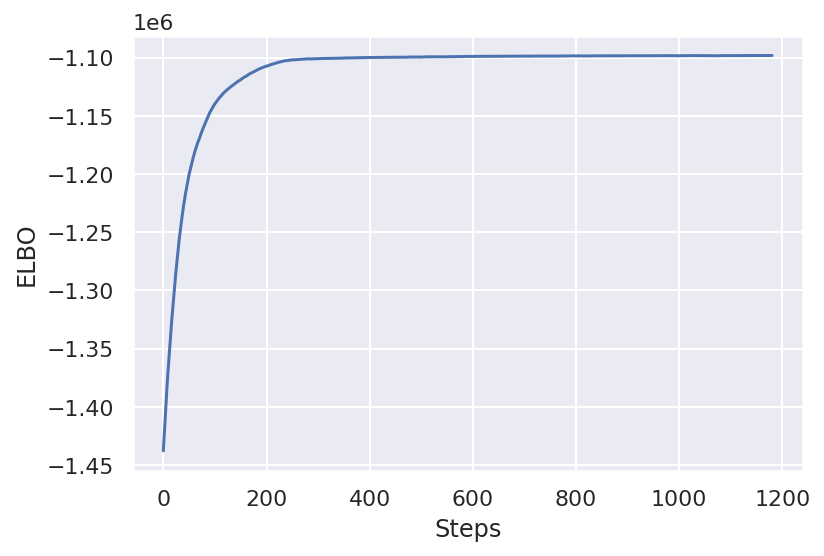

In [11]:
# filter out two expreme runs
# encodings_filtered = {k:v for k, v in all_encodings["language"].items() if k in language_encoding_stats_df_filter.index}

# print(len(encodings_filtered), len(all_encodings["language"]))

LANG_DP_ALPHA = 0.1
LANG_NUM_COMPS = 5
LANG_N_ENCODINGS = 1000 # number of latents per group
LANG_LATENT_DIM = 32
LANG_N_ITER_VI = 1200 # needs to be high, better for finding one comp. for the prior
LANG_N_POST_SAMPLES = 600
LANG_SEED = 0

mm_language_data, mm_language_group_names = prepare_data(encoding_dict=all_encodings["language"], 
                                                         N_encodings=LANG_N_ENCODINGS, 
                                                         latent_dim=LANG_LATENT_DIM, 
                                                         device=DEVICE)

MM_language = MixedMembershipLatentAnalysis(run_names=mm_language_group_names, 
                                            all_latents=mm_language_data.permute(1, 0, 2), 
                                            device=DEVICE, 
                                            seed=LANG_SEED, 
                                            num_components=LANG_NUM_COMPS,
                                            DP_alpha=LANG_DP_ALPHA)

MM_language.fit_mm(plot_elbo=True, n_iterations=LANG_N_ITER_VI)

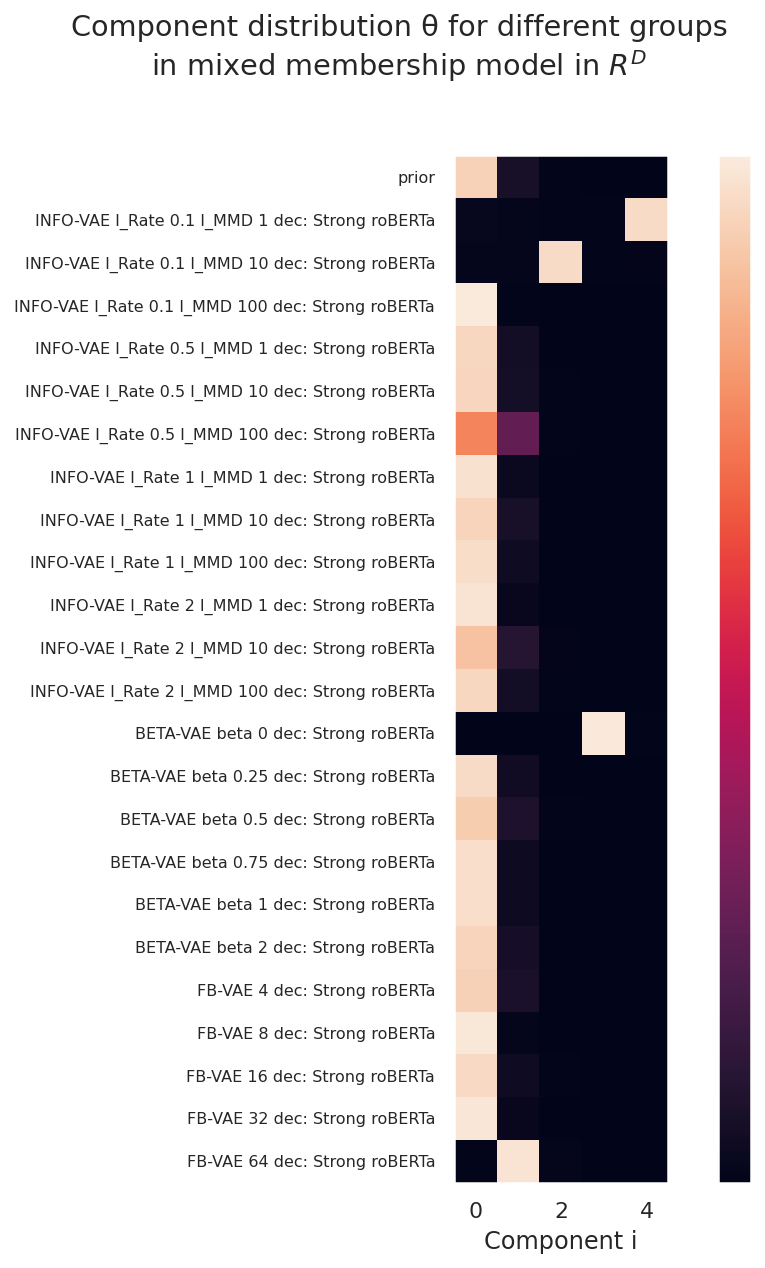

In [12]:
with torch.no_grad():
    MM_language.plot_component_dist_groups(
        posterior_predict_n_samples=LANG_N_POST_SAMPLES, 
        figsize=(6, 8))

In [13]:
kl_dists, kl_avg = kl_comp_data_group_model_groups(MM_language, posterior_predict_n_samples=600, resample_post=False)
torch.save(dict(kl_avg=kl_avg, kl_dists=kl_dists), "language_latent_kl.pt")

In [14]:
# def plot_kl_spread(self, posterior_predict_n_samples=600, resample_post=False):
#     if self.posterior is None or resample_post:
#         self.posterior = self.model.posterior_predict(num_samples=posterior_predict_n_samples)

#     assert "prior" in self.clean_names, "there must be a data group called 'prior'"
#     data_idx = self.clean_names.index("prior")

#     # omegas are comp probs (sum to one)
#     # [S_post, 1, 1, G, T] -> [S_post, G, T]
#     post_omega_all = self.posterior["omega"].squeeze(1).squeeze(1)
#     # [S_post, 1, T]
#     post_omega_data = post_omega_all[:, data_idx, :].unsqueeze(1)

#     post_cat_all = td.Categorical(probs=post_omega_all)
#     post_cat_data = td.Categorical(probs=post_omega_data)

#     # [S_post, G]
#     kl = td.kl_divergence(post_cat_data, post_cat_all)
#     kl_avg = kl.mean(axis=0)
    
#     idx_order = np.argsort(kl_avg.flatten().cpu().numpy())
    
#     fig, axs = plt.subplots(nrows=self.G, figsize=(5, 14))
    
#     for g in idx_order:
#         axs[g].hist(kl[:, g].cpu().numpy(), bins=60, density=True, lw=0)
#         axs[g].axvline(kl_avg[g], linestyle="--", color="black")
#         axs[g].set_xlim([0, 10])
#         axs[g].set_xticklabels([])
#         axs[g].set_yticklabels([])
#         axs[g].set_title(self.clean_names[g], size=6, y=1.0, pad=0.0)
    
#     plt.tight_layout()
#     plt.show()
    
# plot_kl_spread(MM_language, posterior_predict_n_samples=600, resample_post=False)

# Estimate marginal KL with mixture

In [15]:
with torch.no_grad():
    marginal_kl = MM_language.approximate_marginal_kl()

language_encoding_stats_df = language_encoding_stats_df.join(pd.Series(marginal_kl).rename("mm_marginal_KL"))
# sns.pairplot(language_encoding_stats_df)

W0210 16:43:43.023406 23192927092480 _axes.py:4281] *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
W0210 16:43:43.051106 23192927092480 _axes.py:4281] *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
W0210 16:43:43.077262 23192927092480 _axes.py:4281] *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument

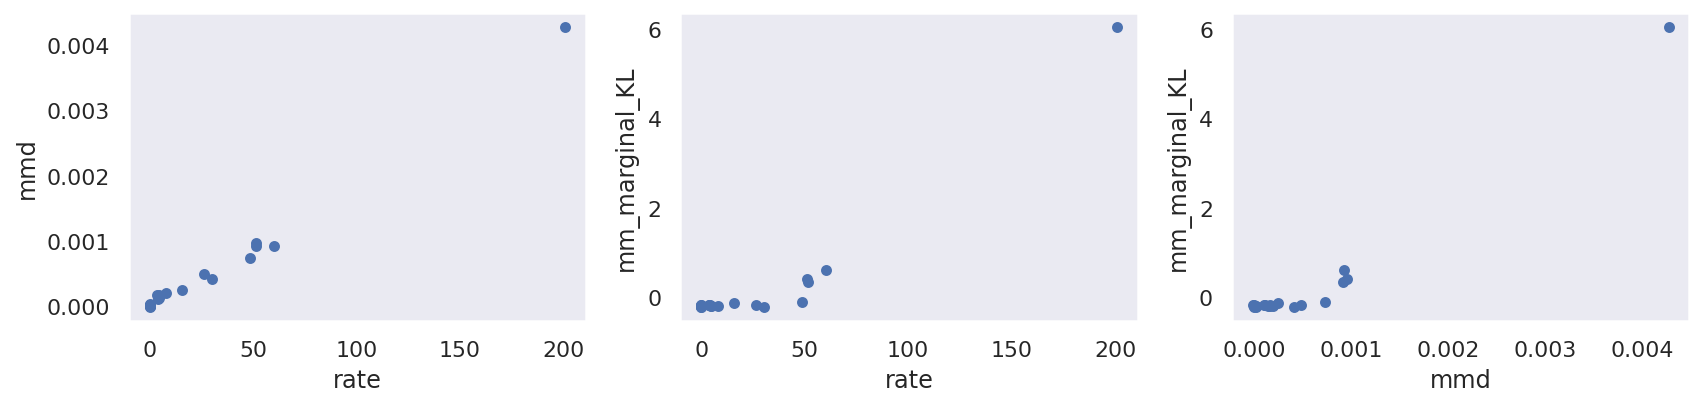

In [16]:
fig, axs = plt.subplots(ncols=3, figsize=(12, 3))
language_encoding_stats_df.plot(kind="scatter", x="rate", y="mmd", ax=axs[0])
language_encoding_stats_df.plot(kind="scatter", x="rate", y="mm_marginal_KL", ax=axs[1])
language_encoding_stats_df.plot(kind="scatter", x="mmd", y="mm_marginal_KL", ax=axs[2])
plt.tight_layout()

In [17]:
# kl_df = plot_kl_comp_data_group_model_groups(MM_language, posterior_predict_n_samples=300, resample_post=False, 
#                                              figsize=(5, 7), global_stats_df=None, kl_df=None,
#                                              plot_against_list=None, plot_against_name_list=None)

In [18]:
# _ = plot_kl_comp_data_group_model_groups(MM_language, figsize=(9, 7), global_stats_df=global_stats_df, 
#                                          kl_df=kl_df,
#                                          plot_against_list=["kl_prior_post", "MMD"], 
#                                          plot_against_name_list=["R", "MMD"])

# ▶ Mixed Membership analysis for image

G=67 S=1000 D=10
Sx=1000, G=67, D=10


/home/cbarkhof/fall-2021/analysis/bda_models/Pyro_BDA/probabll/bda/mmm.py:486: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(groups, device=self.device, dtype=torch.float32)


  0%|          | 0/1200 [00:00<?, ?it/s]

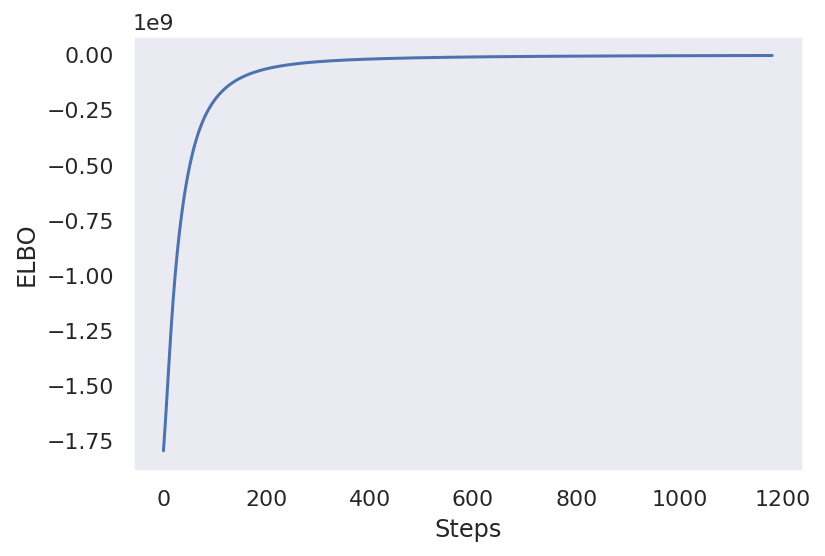

In [19]:
IM_DP_ALPHA = 0.005
IM_NUM_COMPS = 5
IM_N_ENCODINGS = 1000 # number of latents per group
IM_LATENT_DIM = 10
IM_N_ITER_VI = 1200 # needs to be high, better for finding one comp. for the prior
IM_N_POST_SAMPLES = 600
IM_SEED = 0

mm_image_data, mm_image_group_names = prepare_data(encoding_dict=all_encodings["image"], 
                                                   N_encodings=IM_N_ENCODINGS, 
                                                   latent_dim=IM_LATENT_DIM, 
                                                   device=DEVICE)

MM_image = MixedMembershipLatentAnalysis(run_names=mm_image_group_names, 
                                         all_latents=mm_image_data.permute(1, 0, 2), 
                                         device=DEVICE, 
                                         seed=IM_SEED, 
                                         num_components=IM_NUM_COMPS,
                                         DP_alpha=IM_DP_ALPHA)

MM_image.fit_mm(plot_elbo=True, n_iterations=IM_N_ITER_VI)

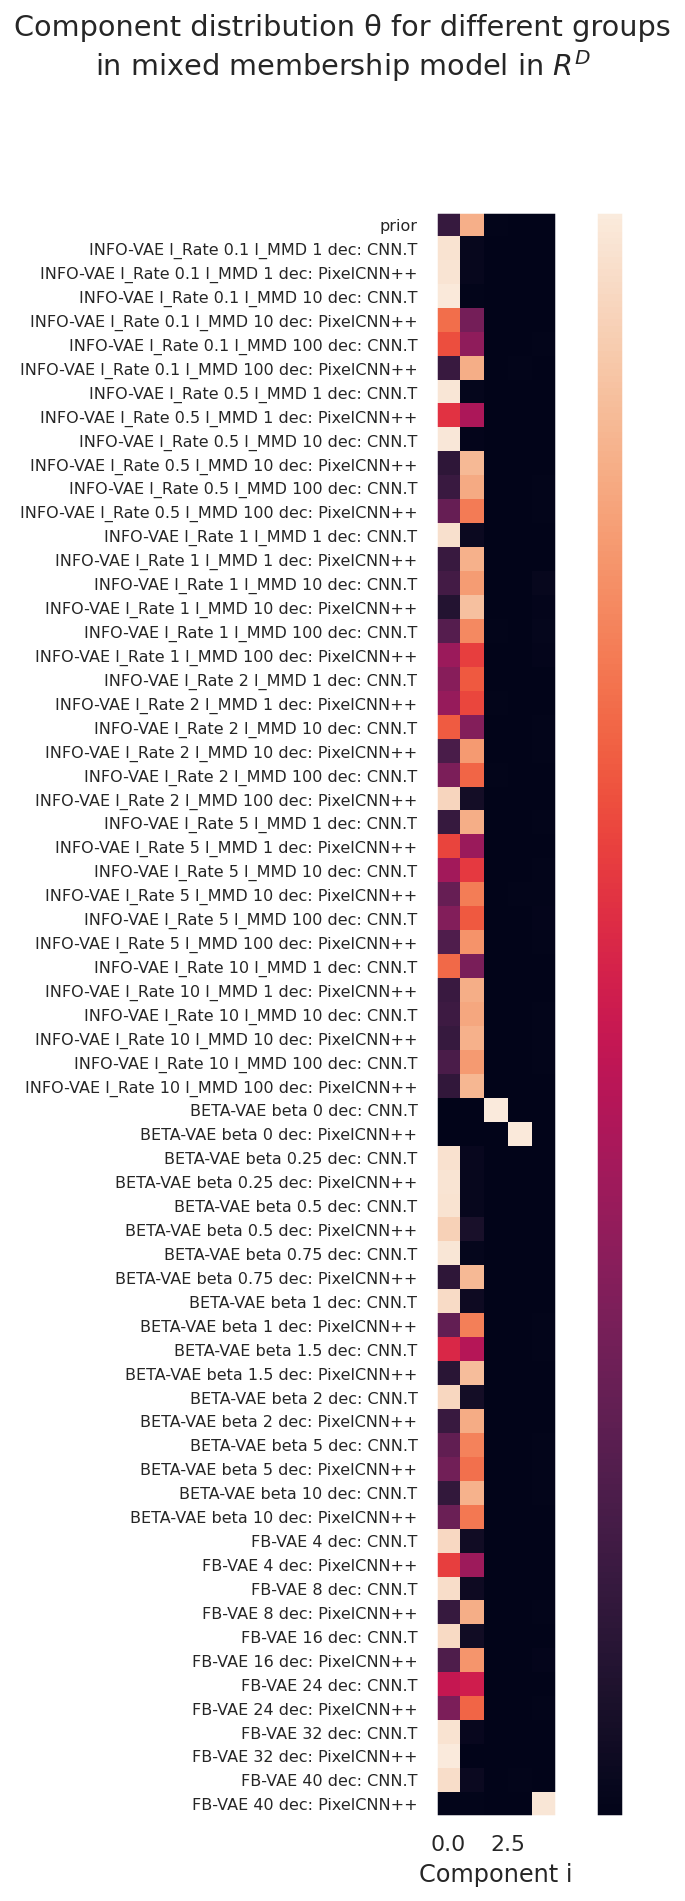

In [20]:
with torch.no_grad():
    MM_image.plot_component_dist_groups(posterior_predict_n_samples=IM_N_POST_SAMPLES, figsize=(5, 12))

In [21]:
kl_dists, kl_avg = kl_comp_data_group_model_groups(MM_image, posterior_predict_n_samples=600, resample_post=False)
torch.save(dict(kl_avg=kl_avg, kl_dists=kl_dists), "image_latent_kl.pt")

In [22]:
with torch.no_grad():
    marginal_kl = MM_image.approximate_marginal_kl()
image_encoding_stats_df = image_encoding_stats_df.join(pd.Series(marginal_kl).rename("mm_marginal_KL"))
# sns.pairplot(image_encoding_stats_df)

W0210 16:45:04.567433 23192927092480 _axes.py:4281] *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
W0210 16:45:04.589839 23192927092480 _axes.py:4281] *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
W0210 16:45:04.611323 23192927092480 _axes.py:4281] *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument

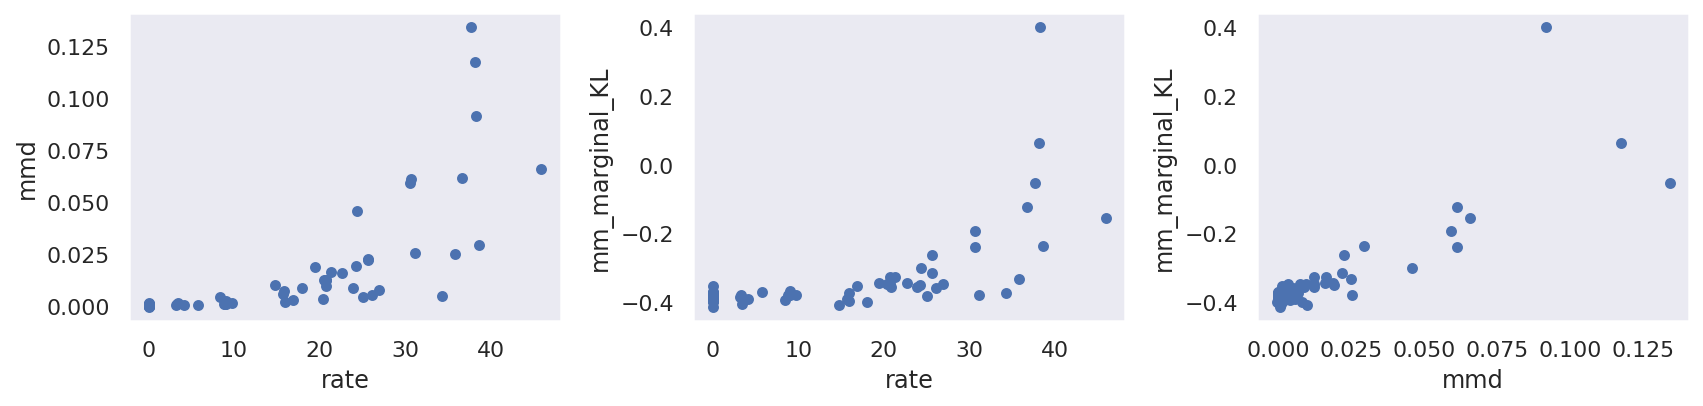

In [23]:
fig, axs = plt.subplots(ncols=3, figsize=(12, 3))
image_encoding_stats_df.plot(kind="scatter", x="rate", y="mmd", ax=axs[0])
image_encoding_stats_df.plot(kind="scatter", x="rate", y="mm_marginal_KL", ax=axs[1])
image_encoding_stats_df.plot(kind="scatter", x="mmd", y="mm_marginal_KL", ax=axs[2])
plt.tight_layout()

In [24]:
kl_df = plot_kl_comp_data_group_model_groups(MM_image, posterior_predict_n_samples=300, resample_post=False, 
                                             figsize=(5, 16), global_stats_df=None, kl_df=None,
                                             plot_against_list=None, plot_against_name_list=None)

_ = plot_kl_comp_data_group_model_groups(MM_image, figsize=(9, 16), global_stats_df=global_stats_df, 
                                         kl_df=kl_df,
                                         plot_against_list=["kl_prior_post", "MMD"], 
                                         plot_against_name_list=["R", "MMD"])

NameError: name 'plot_kl_comp_data_group_model_groups' is not defined